In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from copy import deepcopy

from qibo.backends import construct_backend
from qibo import hamiltonians, Circuit, gates, set_backend
from qibo import gates, symbols
from qibo.gates import Unitary, CNOT, CZ
from qibo.symbols import X, Y, Z
from qibo import hamiltonians
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian

from db_doi.group_commutator_iteration import GroupCommutatorIteration, DoubleBracketRotationApproximationType
from db_doi.utils_XXZ_compilation import *

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [1]:
L = 6
H_XXZ = XXZ_compilation_line(L,gateset="CNOT")

NameError: name 'XXZ_compilation_line' is not defined

In [ ]:
from db_doi.utils_reporting import load_data, simulation_data_path
data_collection = load_data(simulation_data_path() + f"XXZ_HVA_data_L{L}")

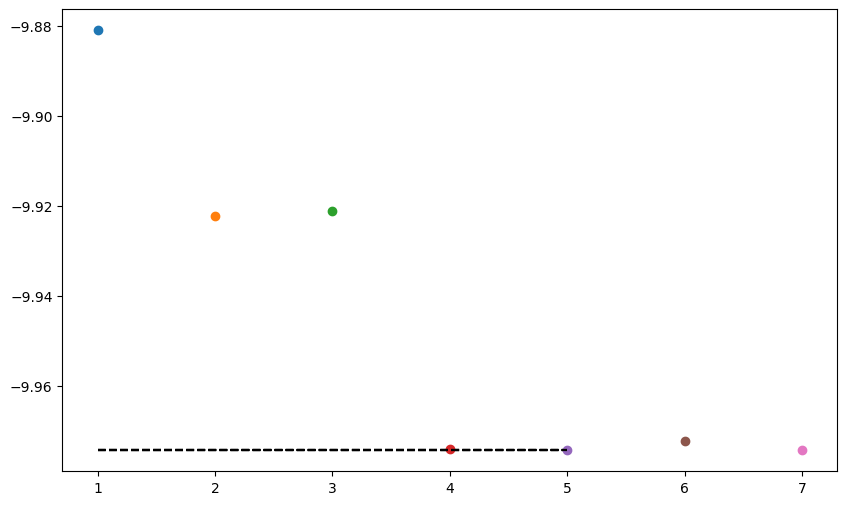

In [8]:
plt.figure(figsize=(10, 6))
for nlayers in range(1,8):
    E_HVA = data_collection[f"HVA_Nlayers_{nlayers}"]["E_HVA"]
    plt.plot(nlayers, E_HVA, 'o', label=f'Nlayers={nlayers}')
    plt.plot(np.arange(1,6), [data_collection["E0"]]*5, 'k--', label='E0')

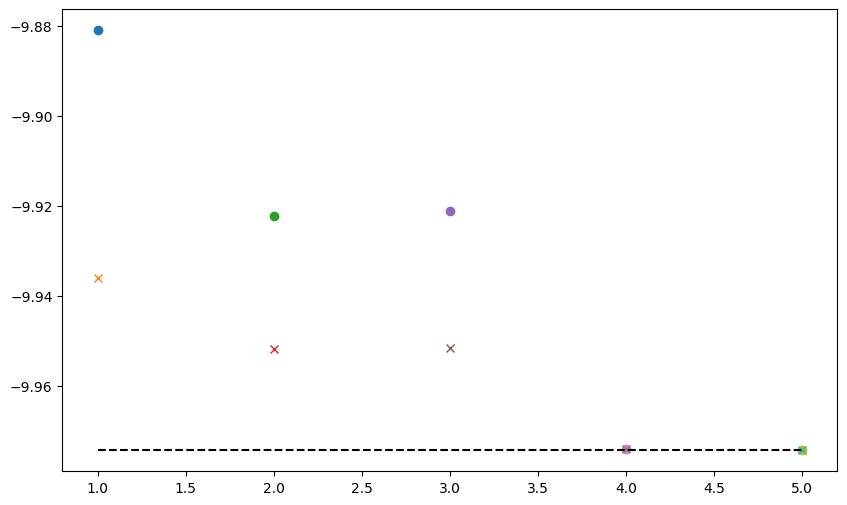

In [24]:
from db_doi.utils_reporting import load_data
data_collection = load_data(simulation_data_path() + f"XXZ_HVA_data_L{L}.pickle")
plt.figure(figsize=(10, 6))
for nlayers in range(1,6):
    E_HVA = data_collection[f"HVA_Nlayers_{nlayers}"]["E_HVA"]
    plt.plot(nlayers, E_HVA, 'o', label=f'Nlayers={nlayers}')
    plt.plot(nlayers, gci[nlayers].loss(), 'x', label=f'GCI loss Nlayers={nlayers}')
plt.plot(np.arange(1,6), [E0]*5, 'k--', label='E0')

In [ ]:
from collections import Counter
two_qubit_counter = lambda circ: sum(1 for gate in circ.queue if len(gate.qubits) == 2)

doi = hamiltonians.SymbolicHamiltonian(
    sum([ Z(i) for i in range(L)]))
from db_doi.utils_reporting import take_verbose_step
gci_results = {}

for nlayers in range(1,6):

    init_circ = data_collection[f"HVA_Nlayers_{nlayers}"]["circuit"]

    gci = GroupCommutatorIteration(
                            h=deepcopy(H_XXZ),
                            preparation_circuit=init_circ)
    
    db_doi_two_qubit_counts = [ two_qubit_counter(init_circ) ]
    db_doi_energies =  [ gci[nlayers].loss() ]
    db_doi_circuits = [deepcopy(init_circ)]
    for step in range(5):
        print("--------------------------")
        print(f"Step {step+1}")   

        step_grid = np.linspace(0.001, 0.05, 15)
        s_opt, s_min, losses, _ = gci.choose_step(
            dbf, step_grid=step_grid)
        print("Step grid:", step_grid)
        print("Losses:", losses)
        print(f"Optimal step: {s_opt}")
        print(f"Minimum loss: {s_min}")
        plt.figure()
        plt.plot(step_grid, losses, marker='o')
        plt.xlabel('Step size')
        plt.ylabel('Loss')
        plt.title('Loss vs Step size for gci_hva.choose_step')
        plt.show()
    
        gci(s_opt, dbf)
        print("Circuit analysis after:")
        print_gate_count_report(gci.preparation_circuit)  
        dbf_dbqa_two_qubit_counts.append( two_qubit_counter(gci.preparation_circuit))
        dbf_dbqa_energies.append( gci.loss() )  
    data_collection[f"GCI_HVA_Nlayers_{nlayers}"] = { "gci": gci, "nlayers": nlayers, "energies": db_doi_energies,
                                                      "two_qubit_counts": db_doi_two_qubit_counts,
                                                      "circuit": db_doi_circuits }
    gci_results[nlayers] = gci
data_collection["gci_results"] = gci_results

from db_doi.utils_reporting import save_data
save_data(data_collection, simulation_data_path() + f"XXZ_GCI_x_HVA_data_L{L}")



AttributeError: 'dict' object has no attribute 'loss'

In [11]:
plt.figure()
plt.plot(dbf_dbqa_two_qubit_counts, dbf_dbqa_energies, marker='o')
plt.xlabel('Two-qubit gate count')
plt.ylabel('Energy')
plt.title('Energy vs Two-qubit gate count for DBF-DBQA')
plt.show()

NameError: name 'dbf_dbqa_energies' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
doi = hamiltonians.SymbolicHamiltonian(
    sum([ Z(i) for i in range(L)]))
from db_doi.utils_reporting import take_verbose_step
gci = {}
for nlayers in range(1,6):
    init_circ = data_collection[f"HVA_Nlayers_{nlayers}"]["circuit"]
    gci[nlayers] = GroupCommutatorIteration(
    h=deepcopy(H_XXZ),
    preparation_circuit=init_circ,
    double_bracket_rotation_approximation_type=DoubleBracketRotationApproximationType.group_commutator_reduced)
    take_verbose_step(gci[nlayers], doi)

In [ ]:
import pickle

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data


path = "../simulation_results/Qrisp_simulations_DB_QITE_and_QPE/data/benchmarks_2nd_L=16_05-21-18"
db_qite_simulation_results = load_data(path)
db_qite_energies = db_qite_simulation_results[1]['optimal_energies']
db_qite_cz_counts = [db_qite_simulation_results[0]['circuit_data'][0][i]['cz'] for i in range(len(db_qite_energies))]
print(db_qite_energies)

[np.float64(-26.971036078151435), np.float64(-27.387533684571018), np.float64(-27.516956618690205), np.float64(-27.56818922719701), np.float64(-27.59337703920386), np.float64(-27.608655432129435)]


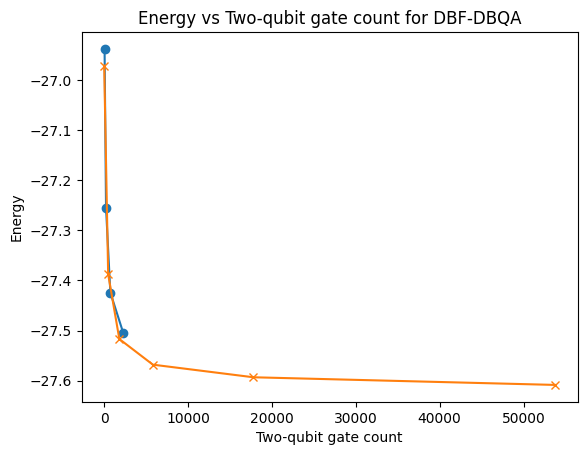

In [ ]:
plt.figure()
plt.plot(dbf_dbqa_two_qubit_counts, dbf_dbqa_energies, marker='o')
plt.plot(db_qite_cz_counts, db_qite_energies, marker='x', label='DB-QITE')
plt.xlabel('Two-qubit gate count')
plt.ylabel('Energy')
plt.title('Energy vs Two-qubit gate count for DBF-DBQA')
plt.show()

Step grid: [0.0051     0.00830714 0.01151429 0.01472143 0.01792857 0.02113571
 0.02434286 0.02755    0.03075714 0.03396429 0.03717143 0.04037857
 0.04358571 0.04679286 0.05      ]
Losses: [np.float64(-27.092459028187342), np.float64(-27.158460666880877), np.float64(-27.205527537964173), np.float64(-27.236253436504075), np.float64(-27.25255277529906), np.float64(-27.25589097757097), np.float64(-27.247413016219888), np.float64(-27.228026034499347), np.float64(-27.198456805791746), np.float64(-27.159293649907102), np.float64(-27.111017957146412), np.float64(-27.054028376850987), np.float64(-26.98865962616755), np.float64(-26.91519724324013), np.float64(-26.833889220979433)]
Optimal step: 0.021135714285714285
Minimum loss: -27.25589097757097


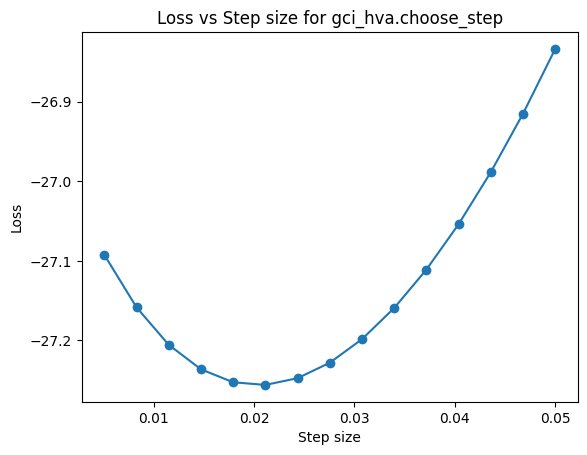

-----
Circuit analysis before:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 17
Total gate count: 152
Gate counts:
  X: 16
  H: 8
  CNOT: 53
  RZ: 45
  RY: 30
Number of gates with generic Unitary type acting on exactly 1 qubit: 0
Number of gates acting on exactly 2 qubits: 53
Circuit analysis after:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 75
Total gate count: 696
Gate counts:
  Unitary: 64
  X: 48
  H: 24
  CNOT: 225
  RZ: 201
  RY: 134
Number of gates with generic Unitary type acting on exactly 1 qubit: 64
Number of gates acting on exactly 2 qubits: 225


In [ ]:
from dbf_dbqa.utils_reporting import take_verbose_step   
take_verbose_step(gci_hva,dbf)

Step grid: [0.0051     0.00830714 0.01151429 0.01472143 0.01792857 0.02113571
 0.02434286 0.02755    0.03075714 0.03396429 0.03717143 0.04037857
 0.04358571 0.04679286 0.05      ]
Losses: [np.float64(-27.348963220530898), np.float64(-27.386797424583666), np.float64(-27.410614003594645), np.float64(-27.42207143844543), np.float64(-27.42267981657917), np.float64(-27.41378095637514), np.float64(-27.396549227001277), np.float64(-27.37200004572888), np.float64(-27.34100147002064), np.float64(-27.304286921966142), np.float64(-27.262468100808068), np.float64(-27.216047596426936), np.float64(-27.165430943987165), np.float64(-27.11093798204561), np.float64(-27.05281344602845)]
Optimal step: 0.01792857142857143
Minimum loss: -27.42267981657917


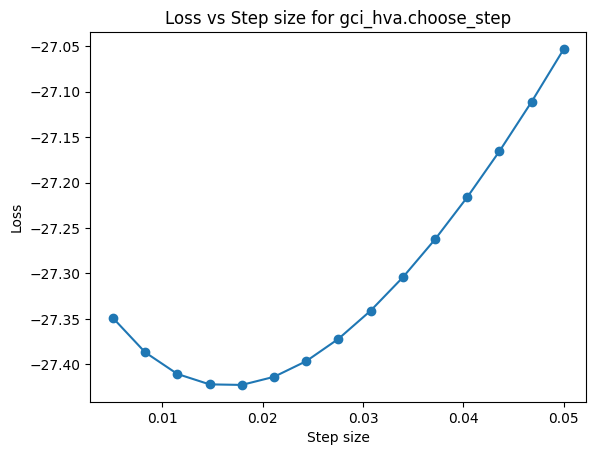

-----
Circuit analysis before:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 75
Total gate count: 696
Gate counts:
  Unitary: 64
  X: 48
  H: 24
  CNOT: 225
  RZ: 201
  RY: 134
Number of gates with generic Unitary type acting on exactly 1 qubit: 64
Number of gates acting on exactly 2 qubits: 225
Circuit analysis after:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 249
Total gate count: 2328
Gate counts:
  Unitary: 256
  X: 144
  H: 72
  CNOT: 741
  RZ: 669
  RY: 446
Number of gates with generic Unitary type acting on exactly 1 qubit: 256
Number of gates acting on exactly 2 qubits: 741


In [ ]:
take_verbose_step(gci_hva,dbf)

Step grid: [0.0051     0.00830714 0.01151429 0.01472143 0.01792857 0.02113571
 0.02434286 0.02755    0.03075714 0.03396429 0.03717143 0.04037857
 0.04358571 0.04679286 0.05      ]
Losses: [np.float64(-27.480087793369204), np.float64(-27.4982913414311), np.float64(-27.50600686054565), np.float64(-27.505411855050436), np.float64(-27.49816169161244), np.float64(-27.485474184301566), np.float64(-27.4682102772709), np.float64(-27.446944626002363), np.float64(-27.422025566991405), np.float64(-27.393625349449096), np.float64(-27.36178182342096), np.float64(-27.32643277983847), np.float64(-27.287444037587825), np.float64(-27.244632244949614), np.float64(-27.197783234881705)]
Optimal step: 0.011514285714285715
Minimum loss: -27.50600686054565


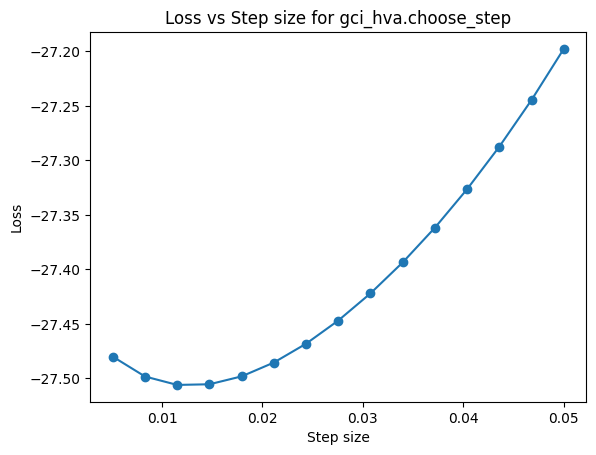

-----
Circuit analysis before:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 249
Total gate count: 2328
Gate counts:
  Unitary: 256
  X: 144
  H: 72
  CNOT: 741
  RZ: 669
  RY: 446
Number of gates with generic Unitary type acting on exactly 1 qubit: 256
Number of gates acting on exactly 2 qubits: 741
Circuit analysis after:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 771
Total gate count: 7224
Gate counts:
  Unitary: 832
  X: 432
  H: 216
  CNOT: 2289
  RZ: 2073
  RY: 1382
Number of gates with generic Unitary type acting on exactly 1 qubit: 832
Number of gates acting on exactly 2 qubits: 2289


In [ ]:
take_verbose_step(gci_hva,dbf)

Step grid: [0.0051     0.00830714 0.01151429 0.01472143 0.01792857 0.02113571
 0.02434286 0.02755    0.03075714 0.03396429 0.03717143 0.04037857
 0.04358571 0.04679286 0.05      ]
Losses: [np.float64(-27.532692260731924), np.float64(-27.537965906858915), np.float64(-27.53700945806073), np.float64(-27.5312829668114), np.float64(-27.52171014778504), np.float64(-27.5088113125842), np.float64(-27.492812430296155), np.float64(-27.473731075367343), np.float64(-27.451442810674013), np.float64(-27.425731666982514), np.float64(-27.396327940438645), np.float64(-27.36293600379545), np.float64(-27.325254336879606), np.float64(-27.282989557482765), np.float64(-27.235865877878783)]
Optimal step: 0.008307142857142857
Minimum loss: -27.537965906858915


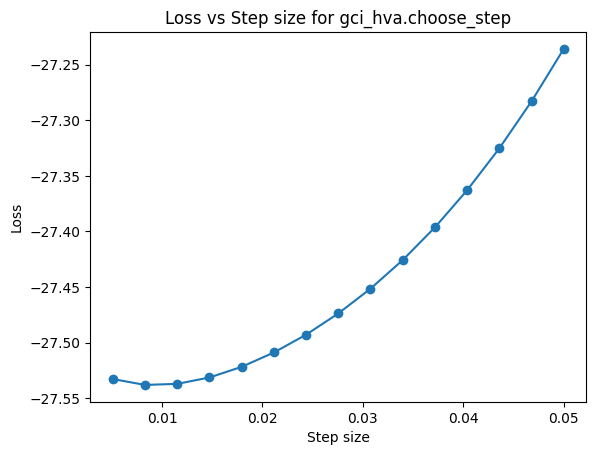

-----
Circuit analysis before:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 771
Total gate count: 7224
Gate counts:
  Unitary: 832
  X: 432
  H: 216
  CNOT: 2289
  RZ: 2073
  RY: 1382
Number of gates with generic Unitary type acting on exactly 1 qubit: 832
Number of gates acting on exactly 2 qubits: 2289
Circuit analysis after:
Gate count report:
-------------------
Number of qubits: 16
Circuit depth: 2337
Total gate count: 21912
Gate counts:
  Unitary: 2560
  X: 1296
  H: 648
  CNOT: 6933
  RZ: 6285
  RY: 4190
Number of gates with generic Unitary type acting on exactly 1 qubit: 2560
Number of gates acting on exactly 2 qubits: 6933


In [ ]:
take_verbose_step(gci_hva,dbf)

In [ ]:
from qrisp.operators import X, Y, Z

import numpy as np
import networkx as nx
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

import pickle

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

def compute_moments(psi, H):
    E = (psi.conj().T @ H.dot(psi)).real
    S = (psi.conj().T @ (H @ H).dot(psi)).real
    return E, S, S - E**2

def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

In [ ]:

path = "../simulation_results/Qrisp_simulations_DB_QITE_and_QPE/data/benchmarks_2nd_L=16_05-21-18"
db_qite_simulation_results = load_data(path)
print(db_qite_simulation_results[1]['optimal_energies'])


In [ ]:
db_qite_simulation_results[1].keys()

dict_keys(['evolution_times', 'optimal_energies', 'variances', 'circuit_data', 'runtimes', 'statevectors'])

In [ ]:
print(db_qite_simulation_results[1]['optimal_energies'])

[np.float64(-26.971036078151435), np.float64(-27.387533684571018), np.float64(-27.516956618690205), np.float64(-27.56818922719701), np.float64(-27.59337703920386), np.float64(-27.608655432129435)]


In [ ]:
print(db_qite_simulation_results[1]['circuit_data'])

[{0: {'u3': 128, 'cz': 68}, 1: {'u3': 1085, 'cz': 660}, 2: {'u3': 3803, 'cz': 2352}, 3: {'u3': 11957, 'cz': 7428}, 4: {'u3': 36419, 'cz': 22656}, 5: {'u3': 109568, 'cz': 68208}}, {0: 16, 1: 18, 2: 18, 3: 18, 4: 18, 5: 18}, {0: 19, 1: 295, 2: 1099, 3: 3511, 4: 10747, 5: 32419}, {0: 16, 1: 18, 2: 18, 3: 18, 4: 18, 5: 18}]


In [ ]:

results_10 = load_data('data/benchmarks_2nd_L=10_05-21-16') 
results_12 = load_data('data/benchmarks_2nd_L=12_05-21-17')
results_14 = load_data('data/benchmarks_2nd_L=14_05-21-17')  
results_16 = load_data('data/benchmarks_2nd_L=16_05-21-18')  
results_18 = load_data('data/benchmarks_2nd_L=18_05-21-19')  
results_20 = load_data('data/benchmarks_2nd_L=20_05-21-22') 

results_QITE = dict()
results_QITE[10] = results_10
results_QITE[12] = results_12
results_QITE[14] = results_14
results_QITE[16] = results_16
results_QITE[18] = results_18
results_QITE[20] = results_20


FileNotFoundError: [Errno 2] No such file or directory: 'data/benchmarks_2nd_L=10_05-21-16.pickle'

IndexError: list index out of range

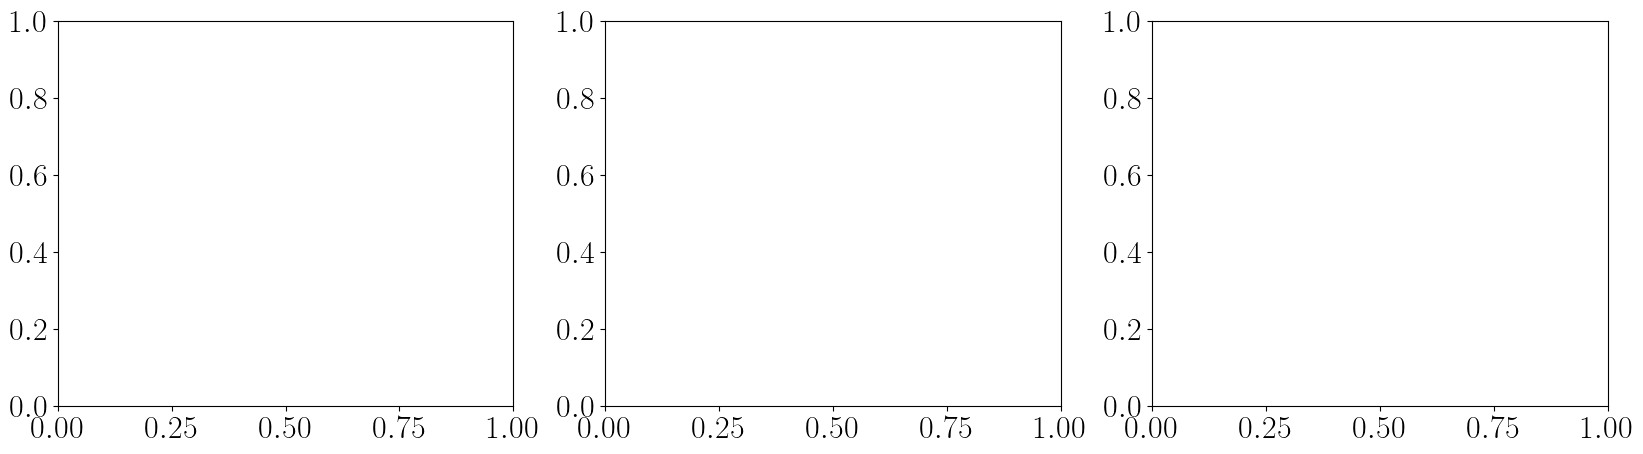

In [ ]:
def generate_plot_E_DBQITE(ax1, L):
    
    lables_energies=[r"~$~\ |\omega_0\rangle =|$Singlet$\rangle = 2^{-L/4}(|01\rangle-|10\rangle)^{\otimes L/2}$",
                     r"~$~\ |\omega_0\rangle =|$HVA$\rangle = U_\mathrm{HVA}|\mathrm{Singlet}\rangle$"]
    lables_fidelities=[r"$F_k\ |$Singlet$\rangle$",r"$F_k\ |$HVA$\rangle$"]
    alphas = [1.0, 0.6]
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    markers = ['o', 's', '^', 'v', '<', '>', 'd']
    indices = [0,1] 
    steps = [0,1,2,3,4,5]

    results = db_qite_simulation_results[L]

    ###############################################################################
    # SUBPLOT 1: Energy
    ###############################################################################

    # 1) Plot energies on the left y-axis
    #for i,ind in enumerate(indices):
        #line1, = ax1.plot(results[ind]['evolution_times'], results[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])
    ind = indices[ 0]
    line1, = ax1.plot(steps, results[ind]['optimal_energies'], label=lables_energies[ind], 
                      color=colors[0], marker='v', linestyle='solid', linewidth=2, zorder=3, alpha = 0.6)
    ind = indices[1]
    line1, = ax1.plot(steps, results[ind]['optimal_energies'], label=lables_energies[ind],
                      color=colors[0], marker=markers[2], linestyle='solid', linewidth=2, zorder=3)

    ax1.axhline(y=E0_val[L], color="red", linestyle=':', alpha=1.0)
    #ax1.axhline(y=E0_val[L]+0.1, color="orange", linestyle=':', alpha=0.8)
    ax1.axhline(y=E1_val[L], color="red", linestyle=':', alpha=0.6)
    
    ax1.set_xlabel(r"Steps $k$")
    ax1.set_ylabel(r"Energy $E_k$")
    ax1.set_xticks(ticks = range(0, 6, 1))
    ax1.set_yticks(ticks = [-30,-31,-32,-33, -34,-35])
    ax1.legend(loc="center right", fontsize=15)
    ax1.set_title(f"DB-QITE for $L={L}$")

    ###############################################################################

    # 3) Combine legends from both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
   
    ax1.legend(lines_1 , labels_1 , loc="best", ncol=1, fontsize=17)

run_param_rc(23)

index = 1 # 0 Singlet, 1 HVA
markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig, ((axE_QITE, axF_QITE, axF_QPE)) = plt.subplots(1, 3, figsize=(20, 5))#, gridspec_kw={"width_ratios": [4,2,10,1]})

###############################################################################
# SUBPLOT 1: Energy and fidelity QITE
###############################################################################

generate_plot_E_DBQITE(axE_QITE,20)
axE_QITE.annotate('a)', xy = (-.2, 1.05), xycoords='axes fraction')
axE_QITE.annotate(' ',
            xy=(5.2, E0_val[20]),  # theta, radius
            xytext=(5.2, -32.6),    # fraction, fraction
            textcoords='data',
            arrowprops=dict(facecolor='gray', shrink=0.001),
            horizontalalignment='left',
            verticalalignment='bottom')
axE_QITE.annotate(' ',
            xy=(4.8, -34),  # theta, radius
            xytext=(4.8, -33.1),    # fraction, fraction
            textcoords='data',
            arrowprops=dict(facecolor='gray', shrink=0.001),
            horizontalalignment='left',
            verticalalignment='bottom')
axE_QITE.set_xlim([-0.1,5.35])
axE_QITE.text(
    4.4,           
    -33,       
    r"$\lambda_1$",                          
    va="center",
    ha="left",
    color="black",
    alpha = 0.6
)   

axE_QITE.text(
    4.8,           
    -32.5  ,           
    r"$\lambda_0$",                           
    va="center",
    ha="left",
    color="black"
    )
###############################################################################
# SUBPLOT 2: Fidelity and CZ count QITE
###############################################################################

#generate_fidelity_cz_qite(axF_QITE, "HVA")
ax = axF_QITE
init_type="HVA"

if init_type=="Singlet":
    index = 0
    ax.set_title(r"DB-QITE for $|$Singlet$\rangle$")
if init_type=="HVA":
    index = 1
    ax.set_title(r"DB-QITE for $|$HVA$\rangle$")

steps = list(range(0,6))

cz_data_qite = dict()

for i,L in enumerate(list(range(10,22,2))):
    results = db_qite_simulation_results[L]
    cz = np.array([results[index]["circuit_data"][0][k]['cz'] for k in steps])
    cz_data_qite[L] = cz

alphas =[0.5,0.75,1,0.7]
cz_count_HVA = {}
fidelities_HVA = {}
ax2 = ax.twinx()
for i,L in enumerate([12,16,20]):
    results = db_qite_simulation_results[L]

    psi = E0_vec[L] # ground state
    states = results[index]["statevectors"]
    fidelities = []
    for phi in states:
        fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

    cz_counts = cz_data_qite[L]
    cz_count_HVA[L] = cz_data_qite[L][0]
    fidelities_HVA[L] = fidelities[0]
    ax2.plot(cz_counts, fidelities, marker=markers[i], zorder = 4+i, label=f'$L={L}$',color= colors[0], alpha = alphas[i])


ax.legend(loc="best", ncols=2, fontsize=15)
#ax.set_xticks(ticks = range(0, 6, 1))
ax.set_xscale('log')
ax.set_xlabel(r"Number of CZ gates")
ax.set_ylabel(r"Fidelity $F_k$")
ax.set_title(r"DB-QITE and QPE for $|$HVA$\rangle$")

steps = list(range(1,6))

cz_data_qpe = dict()
for i,L in enumerate([12,16,20]):
    cz = [results_QPE[index][L][k]['ops']['cz'] for k in steps]
    cz.insert(0, cz_count_HVA[L])
    cz_data_qpe[L] = cz


for i,L in enumerate([12,16,20]):
    fidelities = [results_QPE[index][L][k]['F0'] for k in steps]
    fidelities.insert(0, fidelities_HVA[L])
    cz_counts = cz_data_qpe[L]
    #adding the initialization data
    ax.plot(cz_counts, fidelities, marker=markers[i], label=f'$L={L}$', zorder = i, color= colors[1], alpha = alphas[i], markerfacecolor='none')
if init_type=="HVA":
    steps = list(range(1,8))


ax.axhline(y=1, color="orange", linestyle=':', alpha=1.0,linewidth = 1)
ax.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8,linewidth = 1)
ax.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6,linewidth = 1)
ax.legend(loc="best", ncols=1, fontsize=16, title='QPE',title_fontsize='17', bbox_to_anchor=(0.715, 0.42))
ax2.legend(loc="best", ncols=1, fontsize=16, title='DB-QITE',title_fontsize='17', bbox_to_anchor=(0.715, 0.795))

ax.set_xscale('log')
#ax.set_xticks(ticks = range(1, 6, 1))
ax.set_xlabel(r"Number of CZ gates")   
ax.set_ylabel(r"Fidelity $F_k$")
    
axF_QITE.annotate('b)', xy = (-.2, 1.05), xycoords='axes fraction')
#axF_QITE.annotate(r'DB-QITE', xy=(1e4,0.98), textcoords='data', fontsize=15,rotation=90)
#axF_QITE.annotate(r'QPE', xy=(1e4,0.75), textcoords='data', fontsize=15,rotation=90)
###############################################################################
# SUBPLOT 3: Fidelity and CZ count QPE
###############################################################################

L = 20
index = 1 # HVA

results = db_qite_simulation_results[L]

psi = E0_vec[L] # ground state
states = results[index]["statevectors"]
fidelities = []
for phi in states:
    fidelities.append(np.round(np.abs(np.dot(psi.conj().transpose(),phi))**2,3))

cz_counts = cz_data_qite[L]
axF_QPE.plot(cz_counts, fidelities, marker=markers[2], label=f'DB-QITE',color= colors[0], alpha = alphas[i])

steps = list(range(1,6))
fidelities = [results_QPE[index][L][k]['F0'] for k in steps]
fidelities.insert(0, fidelities_HVA[L])
cz_counts = cz_data_qpe[L]
axF_QPE.plot(cz_counts, fidelities, marker=markers[2], label=f'QPE $[0,1)$', color= colors[1], alpha = 0.5)

steps = list(range(1,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fidelities = [results_QPE_rescaled_05[index][20][k]['F0'] for k in steps]
fidelities.insert(0, fidelities_HVA[L])
cz_counts = [results_QPE_rescaled_05[index][20][k]['ops']['cz'] for k in steps]
cz_counts.insert(0, cz_count_HVA[L])
axF_QPE.plot(cz_counts, fidelities, color=colors[1], label=f'QPE $[0,0.5)$'
             , marker=markers[3], markerfacecolor='none', alpha = 0.75)


fidelities = [results_QPE_rescaled_01[index][20][k]['F0'] for k in steps]
fidelities.insert(0, fidelities_HVA[L])
cz_counts = [results_QPE_rescaled_01[index][20][k]['ops']['cz'] for k in steps]
cz_counts.insert(0, cz_count_HVA[L])

axF_QPE.plot(cz_counts, fidelities, color=colors[1], label=f'QPE $[0,0.1)$'
             , marker=markers[4], markerfacecolor='none',alpha = 1)

axF_QPE.axhline(y=1, color="orange", linestyle=':', alpha=1.0,linewidth = 1)
axF_QPE.axhline(y=0.975, color="orange", linestyle=':', alpha=0.8,linewidth = 1)
axF_QPE.axhline(y=0.95, color="orange", linestyle=':', alpha=0.6,linewidth = 1)

axF_QPE.annotate('c)', xy = (-.12, 1.05), xycoords='axes fraction')
axF_QITE.annotate(r'$k=0$', xy=(37,0.917), textcoords='data', fontsize=17,zorder = 11)
axF_QITE.annotate(r'$k=1$', xy=(170,0.957), textcoords='data', fontsize=17,zorder = 12)
axF_QITE.annotate(r'$k=2$', xy=(625,0.983), textcoords='data', fontsize=17,zorder = 13)
#axF_QPE.annotate(r'$L=20,$', xy=(16100,0.87), textcoords='data', fontsize=15)
#axF_QPE.annotate(r'$[0,0.5)$', xy=(16100,0.85), textcoords='data', fontsize=15)
#axF_QPE.annotate(r'$L=20,$', xy=(39000,0.795), textcoords='data', fontsize=15)
#axF_QPE.annotate(r'$[0,0.1)$', xy=(39000,0.7753), textcoords='data', fontsize=15)
axF_QPE.set_xscale('log')
axF_QPE.set_xlabel(r"Number of CZ gates")  
axF_QPE.set_title(r"DB-QITE vs. spectral rescalings of QPE")
axF_QPE.legend(loc="upper left", ncols=1, fontsize=17)#,title=f'$L=20$',title_fontsize='15')
plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg_main.pdf")

In [ ]:
# check rxx formula
t = 0.5
qc = Circuit(2)
qc.add(gates.RXX(0, 1, t*2))
x = np.array([[0,1], [1,0]])
xx = np.kron(x, x)
u = sp.linalg.expm(-1j*t*xx)
print(np.linalg.norm(u-qc.unitary())<1e-11)

True


In [ ]:
def XXZ_simulation(nqubits, delta, t, trotter_steps=2, boundary="open", layer=3):
    qc = Circuit(nqubits)
    even_pairs = [(i, i+1) for i in range(0, nqubits-1, 2)]
    odd_pairs = [(i, i+1) for i in range(1, nqubits-1, 2)]
    if boundary == 'closed':
        odd_pairs.append((0, nqubits-1))
        
    dt_even = t/trotter_steps*2
    dt_odd = t/trotter_steps*2
    if layer == 3:
        dt_even /= 2
        
    for _ in range(trotter_steps):
        for i,j in even_pairs:
            qc.add(gates.RXX(i, j, dt_even))
            qc.add(gates.RYY(i, j, dt_even))
            qc.add(gates.RZZ(i, j, dt_even*delta))
        for i, j in odd_pairs:
            qc.add(gates.RXX(i, j, dt_odd))
            qc.add(gates.RYY(i, j, dt_odd))
            qc.add(gates.RZZ(i, j, dt_odd*delta))
        if layer == 3:
            for i,j in even_pairs:
                qc.add(gates.RXX(i, j, dt_even))
                qc.add(gates.RYY(i, j, dt_even))
                qc.add(gates.RZZ(i, j, dt_even*delta))
                
    return qc

In [ ]:
# check hamiltonian simulation
L_test = 6
delta_test = 0.5
boundary_test = 'open'
H_test = construct_XXZ(L_test, delta_test, boundary_test)
t = 0.2
print(np.linalg.norm(sp.linalg.expm(-1j*t*H_test.matrix) - XXZ_simulation(L_test, delta_test, t, layer=3).unitary()))

[Qibo 0.2.21|WARNING|2025-07-29 15:37:49]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[Qibo 0.2.21|WARNING|2025-07-29 15:37:49]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


0.03903661129144955


## Magnetic field

RZ in qibo: $e^{-i\frac{\theta}{2}D}$

In [ ]:
# magnetic field
def magnetic_field_circ(coefs, t):
    # implments e^{-itD}
    nqubits = len(coefs)
    qc = Circuit(nqubits)
    
    for idx, coef in enumerate(coefs):
        qc.add(gates.RZ(idx, coef*t*2))
    return qc 

In [ ]:
# test d formula
theta = 0.5
d = magnetic_field_circ([1], theta)
d_u = sp.linalg.expm(-1j*theta*np.array([[1,0],[0,-1]]))
print(np.linalg.norm(d.unitary()-d_u)<1e-3)

True


## Construct GCI circuit
In the initialization step, we have
$$
\bra{\psi_0(\theta)} H\ket{\psi_0(\theta)}=\bra{0}U_\theta^\dagger H U_\theta\ket{0}=\bra{0}A_0\ket{0}
$$
For one step of DBQA, 
$$
V_1 = e^{itD}U^\dagger e^{-itH_0}Ue^{-itD}
$$
and that
$$
A_1 = V_1^\dagger U^\dagger H_0 U V_1.
$$

With this we find
$$
\langle 0|A_1|0\rangle =\langle \psi_1|H|\psi_1\rangle = \bra 0 U_1^\dagger H U_1\ket 0
$$
where 
$$
|\psi_1\rangle = U* V_1|0\rangle.
$$

Therefore, our composed DBQA circuit should follow

$$
U_1 = U*V_1 = U_\theta e^{itD}U_\theta ^\dagger e^{-itH}U_\theta e^{-itD}
$$

$$
U_1^{(RHOPF)} = U \cdot V_1^{(RHOPF)}=Ue^{-i\phi \sqrt t D}U^\dagger e^{-i\sqrt tH} U
            e^{i(\phi+1)\sqrt t D}U^\dagger e^{i(1-\phi)\sqrt tH} U e^{-i\phi \sqrt t D}.
$$

In [ ]:
def GCI(H, H_sim_fun, D_circ_fun, init_circ, t):
    qc = Circuit(H.nqubits)
    H_sim = H_sim_fun(t)
    D_circ = D_circ_fun(t)
    qc.wire_names = init_circ.wire_names
    D_circ.wire_names = qc.wire_names
    H_sim.wire_names = qc.wire_names
    qc = qc + D_circ + init_circ + H_sim + init_circ.invert() + D_circ.invert() + init_circ
    return qc, h_expectation_from_circ(H, qc)

In [ ]:
# test t=0 same value as E_init
t = 0
coefs = [1] * L
H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
gci_circ, gci_val = GCI(H_XXZ, H_sim_fun, D_circ_fun, init_circ, t)
print(np.abs(gci_val-h_expectation_from_circ(H_XXZ, init_circ))<1e-3)

NameError: name 'h_expectation_from_circ' is not defined

In [ ]:
run_grid_search = False
if run_grid_search:
    t_space = np.linspace(0,0.3,20)
    E_ls = []
    for t in t_space:
        gci_circ, gci_val = GCI(H_XXZ, H_sim_fun, D_circ_fun, init_circ, t)
        E_ls.append(gci_val)

In [ ]:
if run_grid_search:
    E_min = min(E_ls)
    min_idx = E_ls.index(E_min)
    t_min = t_space[min_idx]
    plt.plot(t_space, E_ls)
    plt.scatter(t_min, E_min, color='red', label=f"({t_min:.2f}, {E_min:.2f})")
    plt.title(f'DBQA gain with time - XXZ (L={L})')
    plt.xlabel('time')
    plt.ylabel(r'$\langle H\rangle$')
    plt.legend()

In [ ]:
gci_circ.gate_names

Counter({'h': 384,
         'rzz': 181,
         'sdg': 90,
         's': 90,
         'x': 48,
         'rxx': 46,
         'ryy': 46,
         'rz': 32,
         'cx': 24})

In [ ]:
print("Circuit depth:", gci_circ.depth)
print("Circuit total gate count:", gci_circ.ngates)
print("Circuit CX count:", gci_circ.gate_names['cx'])
print("Estimated equivalent CZ count:", gci_circ.gate_names['cx']+
      gci_circ.gate_names['rxx']+gci_circ.gate_names['ryy']+gci_circ.gate_names['rzz']
      )

Circuit depth: 83
Circuit total gate count: 941
Circuit CX count: 24
Circuit CZ count: 297


## Optimize parameters

### Fixed D optimize t

Here we expect the same value as the grid search but faster run time.

In [ ]:
from scipy.optimize import minimize_scalar
coefs = [1] * L
def objective(t):
    H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
    D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
    gci_circ, gci_val = GCI(H_XXZ, H_sim_fun, D_circ_fun, init_circ, t)
    return gci_val

In [ ]:
res = minimize_scalar(
    objective,                  
    method='brent',    
    options={'maxiter': 15,
             'xtol': 1e-3} 
)
print(res.fun)
print(res.x)

-27.327291516178352
0.14351650971963992


### Optimize both D and t

In [ ]:
from scipy.optimize import minimize
coefs = [1] * L
D_s = coefs + [0.1]
def objective(D_s):
    coefs = D_s[:-1]
    t = D_s[-1]
    H_sim_fun = lambda t: XXZ_simulation(L, delta, t)
    D_circ_fun = lambda t: magnetic_field_circ(coefs, t)
    gci_circ, gci_val = GCI(H_XXZ, H_sim_fun, D_circ_fun, init_circ, t)
    return gci_val

In [ ]:
max_iter = 1000
result = minimize(
    objective,
    D_s,
    method="COBYLA",
    options={"disp": True, "maxiter": max_iter},
    tol=1e-2,
)

print(result.fun)
print(result.x)

Return from COBYLA because the trust region radius reaches its lower bound.
Number of function values = 111   Least value of F = -27.306620269782684
The corresponding X is:
[1.94500013 1.94499979 1.94500054 1.94500004 1.94500005 1.94500031
 1.94500042 1.94499978 1.94500016 1.94499983 1.94500002 1.94500011
 1.99499996 1.00499996 1.9949998  1.98250001 0.09964276]

-27.306620269782684
[1.94500013 1.94499979 1.94500054 1.94500004 1.94500005 1.94500031
 1.94500042 1.94499978 1.94500016 1.94499983 1.94500002 1.94500011
 1.99499996 1.00499996 1.9949998  1.98250001 0.09964276]
